<a href="https://colab.research.google.com/github/Guadito/prediccion_precios_inmobiliarios/blob/main/Prediccion_precios_vivienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Lectura de datos

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.width', 1000)

In [ ]:
# === 💾 Montar Google Drive (solo si estás en Colab) ===
try:
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Data Mining"
    print("✅ Drive montado correctamente.")
except:
    BASE_PATH = "./data"
    print("⚠️ Modo local: asegúrate de tener los datos en la carpeta ./data")


# === 📂 Carga de datos ===
TRAIN_PATH = f"{BASE_PATH}/entrenamiento.zip"
PRED_PATH = f"{BASE_PATH}/a_predecir.csv"

df_ent = pd.read_csv(TRAIN_PATH, index_col="id")
df_pred = pd.read_csv(PRED_PATH, index_col="id")

print(f"✅ Datos cargados correctamente:")
print(f" - Entrenamiento: {df_ent.shape[0]:,} filas")
print(f" - Predicción: {df_pred.shape[0]:,} filas")

## Filtro

In [ ]:
# selección de datos
df_ent = df_ent.loc[(df_ent["price"].notna()) & \
 (df_ent["l2"] == "Capital Federal") & (df_ent["operation_type"] == 'Venta') & \
  (df_ent["property_type"].isin(["Cochera", "Departamento", "Casa"]))]
df_ent.shape

(105489, 24)

In [ ]:
PESOS_POR_DOLAR = 78.5
df_ent.loc[df_ent["currency"] == "ARS", "price"] = df_ent.loc[df_ent["currency"] == "ARS", "price"] / PESOS_POR_DOLAR

# 2. Feature engineering

## Bathrooms, bedrooms, rooms

In [ ]:
df_ent.loc[:,"rooms"]= df_ent["rooms"].fillna(df_ent["bedrooms"]+1)
df_pred.loc[:,"rooms"]= df_pred["rooms"].fillna(df_pred["bedrooms"]+1)

In [ ]:
import re

# Diccionario de patrones con variantes comunes y la cantidad de ambientes correspondientes
room_patterns = {
    r"monoambiente|monoamb|mono ambiente": 1,
   r"un ambiente|1 ambiente|1 amb\.?|1 Amb\.?": 1,
    r"dos ambientes|2 ambientes|2 amb\.?|2 Amb\.?": 2,
    r"tres ambientes|3 ambientes|3 amb\.?|3 Amb\.?": 3,
    r"cuatro ambientes|4 ambientes|4 amb\.?|4 Amb\.?": 4,
    r"cinco ambientes|5 ambientes|5 amb\.?|5 Amb\.?": 5,
    r"seis ambientes|6 ambientes|6 amb\.?|6 Amb\.?": 6,
    r"siete ambientes|7 ambientes|7 amb\.?|7 Amb\.?": 7,
    r"ocho ambientes|8 ambientes|8 amb\.?|8 Amb\.?": 8,
    r"nueve ambientes|9 ambientes|9 amb\.?|9 Amb\.?": 9,
    r"diez ambientes|10 ambientes|10 amb\.?|10 Amb\.?": 10,
    r"once ambientes|11 ambientes|11 amb\.?|11 Amb\.?": 11,
    r"doce ambientes|12 ambientes|12 amb\.?|12 Amb\.?": 12,
    r"trece ambientes|13 ambientes|13 amb\.?|13 Amb\.?": 13,
    r"catorce ambientes|14 ambientes|14 amb\.?|14 Amb\.?": 14,
    r"quince ambientes|15 ambientes|15 amb\.?|15 Amb\.?": 15,
    r"dieciséis ambientes|16 ambientes|16 amb\.?|16 Amb\.?": 16
}

# Función para buscar ambientes en el texto
def extract_rooms(text):
    if pd.isna(text):
        return None
    for pattern, value in room_patterns.items():
        if re.search(pattern, text, flags=re.IGNORECASE):  # Busca el patrón
            return value  # Devuelve el número de ambientes
    return None  # Si no encuentra nada, devuelve None


    # Llenar los valores nulos en la columna 'rooms'
for col in ['description', 'title']:
    df_ent['rooms'] = df_ent['rooms'].fillna(
        df_ent[col].apply(extract_rooms))

# Llenar los valores nulos en la columna 'rooms'
for col in ['description', 'title']:
    df_pred['rooms'] = df_pred['rooms'].fillna(
        df_pred[col].apply(extract_rooms))

In [ ]:
# Definir promedios por tipo de propiedad
average_m2_per_room = {
    'Departamento': 20,
    'Casa': 25}

# Imputar valores de rooms a ent
for property_type, avg_m2 in average_m2_per_room.items():
    df_ent.loc[
        (df_ent['rooms'].isna()) &
        (df_ent['property_type'] == property_type) &
        (df_ent['surface_covered'].notna()),
        'rooms'
    ] = (df_ent['surface_covered'] / avg_m2).round()


# Imputar valores de rooms a pred
for property_type, avg_m2 in average_m2_per_room.items():
    df_pred.loc[
        (df_pred['rooms'].isna()) &
        (df_pred['property_type'] == property_type) &
        (df_pred['surface_covered'].notna()),
        'rooms'
    ] = (df_pred['surface_covered'] / avg_m2).round()

In [ ]:
df_ent.loc[:,"bedrooms"]= df_ent["bedrooms"].fillna(df_ent["rooms"]-1)
df_pred.loc[:,"bedrooms"]= df_pred["bedrooms"].fillna(df_pred["rooms"]-1)

In [ ]:
df_ent.loc[(df_ent['bathrooms'].isna()) & (df_ent['rooms'] == 1), 'bathrooms'] = 1
df_ent.loc[df_ent['bathrooms'].isna(), 'bathrooms'] = (df_ent['rooms'] / 2).round()

df_pred.loc[(df_pred['bathrooms'].isna()) & (df_pred['rooms'] == 1), 'bathrooms'] = 1
df_pred.loc[df_pred['bathrooms'].isna(), 'bathrooms'] = (df_pred['rooms'] / 2).round()

In [ ]:
df_ent.loc[df_ent["property_type"]== "Cochera", ['rooms', 'bedrooms', 'bathrooms']] = 0
df_pred.loc[df_pred["property_type"]== "Cochera", ['rooms', 'bedrooms', 'bathrooms']] = 0

## Surface

In [ ]:
#relleno una surface con otra en caso de que sea nula
df_ent["surface_total"] = df_ent["surface_total"].fillna(df_ent["surface_covered"])
df_pred["surface_total"] = df_pred["surface_total"].fillna(df_pred["surface_covered"])


df_pred['surface_covered'] = df_pred['surface_covered'].fillna(df_pred['surface_total'])
df_ent['surface_covered'] = df_ent['surface_covered'].fillna(df_ent['surface_total'])


df_ent = df_ent.loc[df_ent["surface_total"].notna()]

In [ ]:
#ratio de superficie cubierta sobre superficie total
df_ent['ratio_sup'] = df_ent['surface_covered']/((df_ent['surface_total'])+0.0001).copy()
df_pred['ratio_sup'] = df_pred['surface_covered']/((df_pred['surface_total'])+0.0001).copy()

/tmp/ipython-input-14-4268659862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['ratio_sup'] = df_ent['surface_covered']/((df_ent['surface_total'])+0.0001).copy()


In [ ]:
#ratio de rooms
df_ent['ratio_rooms'] = df_ent['rooms']/((df_ent['surface_total'])+0.0001).copy()
df_pred['ratio_rooms'] = df_pred['rooms']/((df_pred['surface_total'])+0.0001).copy()

/tmp/ipython-input-15-2703700160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['ratio_rooms'] = df_ent['rooms']/((df_ent['surface_total'])+0.0001).copy()


In [ ]:
# ratio sup x room
df_ent['surface_per_room'] = df_ent['surface_total']/((df_ent['rooms'])+0.0001).copy()
df_pred['surface_per_room'] = df_pred['surface_total']/((df_pred['rooms'])+0.0001).copy()

/tmp/ipython-input-16-464509427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['surface_per_room'] = df_ent['surface_total']/((df_ent['rooms'])+0.0001).copy()


In [ ]:
#Filtro propiedades que tengan estas características
df_ent = df_ent[df_ent['ratio_rooms'] <= 0.1]
df_ent = df_ent[df_ent['rooms'] <= 16]
df_ent = df_ent[df_ent['bathrooms'] <= 8]
df_ent = df_ent[df_ent['bedrooms'] <= 12]

## Price

In [ ]:
df_ent.loc[df_ent["l3"] == "Distrito Audiovisual", "l3"] = "Chacarita"
df_ent.loc[df_ent["l3"] == "Catalinas", "l3"] = "Retiro"
df_ent.loc[:, "l4"] = df_ent["l4"].fillna(df_ent["l3"])


df_pred.loc[df_pred["l3"] == "Distrito Audiovisual", "l3"] = "Chacarita"
df_pred.loc[df_pred["l3"] == "Catalinas", "l3"] = "Retiro"
df_pred.loc[:, "l4"] = df_pred["l4"].fillna(df_pred["l3"])


# Asignación de nombres específicos a la columna 'l4' en el DataFrame
df_pred.loc[172269, 'l4'] = 'Boca'
df_pred.loc[381755, 'l4'] = 'Boca'
df_pred.loc[744025, 'l4'] = 'Paternal'
df_pred.loc[127612, 'l4'] = 'Nuñez'
df_pred.loc[161005, 'l4'] = 'Villa Luro'
df_pred.loc[200179, 'l4'] = 'Villa del Parque'
df_pred.loc[301516, 'l4'] = 'Las Cañitas'
df_pred.loc[957343, 'l4'] = 'Villa Urquiza'


In [ ]:
#Cálculo pm2 individual
df_ent["price_m2"] = df_ent["price"] / (df_ent["surface_total"] + 0.001)

/tmp/ipython-input-20-359067426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent["price_m2"] = df_ent["price"] / (df_ent["surface_total"] + 0.001)


In [ ]:
#Filtro
df_ent = df_ent[(df_ent["price_m2"] >= 500) & (df_ent["price_m2"] <= 10000)]

In [ ]:
#Matriz de pm2 por tipo de propiedad y barrio
gb = df_ent.groupby(by=["property_type", "l4"])["price_m2"].mean().reset_index()
gb.rename(columns={'price_m2': 'precio_m2_barrio'}, inplace=True)
gb['precio_m2_barrio'] = gb['precio_m2_barrio'].round(0)

In [ ]:
#Incorporación al dataset de pm2 del barrio
df_ent = df_ent.reset_index()
df_ent = df_ent.merge(gb, on=['l4', 'property_type'], how='left')
df_ent['precio_m2_barrio'] = df_ent['precio_m2_barrio'].round(0)
df_ent = df_ent.set_index('id')

In [ ]:
#Diferencia entre pm2 individual y barrio
df_ent['dff_pm2'] = df_ent['price_m2'] - df_ent['precio_m2_barrio']

In [ ]:
#df_ent[(df_ent['l4'] == "Belgrano") & (df_ent['property_type'] == "Casa")]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,description,property_type,operation_type,price,ratio_sup,ratio_rooms,surface_per_room,price_m2,precio_m2_barrio,dff_pm2
id,,,,,,,,,,,,,,,,,,,,,
4406,Propiedad,2019-10-01,2020-06-01,2019-10-01,NaN,NaN,Argentina,Capital Federal,Belgrano,Belgrano,...,CODIGO: 3900-75 ubicado en: Munich 1700 - Pub...,Casa,Venta,260000.0,0.571428,0.028571,34.998833,2476.166894,2952.0,-475.833106
4407,Propiedad,2019-10-01,2020-03-07,2019-10-01,NaN,NaN,Argentina,Capital Federal,Belgrano,Belgrano,...,CODIGO: 3900-93 ubicado en: Munich 1700 - Pub...,Casa,Venta,250000.0,0.618556,0.030928,32.332256,2577.293018,2952.0,-374.706982
4528,Propiedad,2019-10-01,9999-12-31,2019-10-01,-58.467380,-34.572498,Argentina,Capital Federal,Belgrano,Belgrano,...,Excelente chalet de estilo ingles ubicado en B...,Casa,Venta,1380000.0,1.000000,0.017794,56.198876,4911.014552,2952.0,1959.014552
21819,Propiedad,2019-07-25,2019-12-19,2019-07-25,-58.446369,-34.567543,Argentina,Capital Federal,Belgrano,Belgrano,...,Imponente mansión de estilo francés ubicada en...,Casa,Venta,3600000.0,1.000000,0.006667,149.998125,2999.997500,2952.0,47.997500
22219,Propiedad,2019-09-07,9999-12-31,2019-09-07,-58.439433,-34.554655,Argentina,Capital Federal,Belgrano,Belgrano,...,"Impecable casa ubicada en el Bajo Belgrano, a ...",Casa,Venta,1200000.0,0.875000,0.015000,66.665556,2999.992500,2952.0,47.992500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989610,Propiedad,2019-08-01,2019-08-13,2019-08-01,-58.443687,-34.567484,Argentina,Capital Federal,Belgrano,Belgrano,...,Excelemte casa estilo Tudor en inmejorable zon...,Casa,Venta,1350000.0,1.000000,0.010989,90.998180,2967.026446,2952.0,15.026446
989611,Propiedad,2019-08-01,2019-08-14,2019-08-01,-58.464492,-34.572551,Argentina,Capital Federal,Belgrano,Belgrano,...,Si buscas vivir en una casa con construcción s...,Casa,Venta,4000000.0,1.000000,0.008224,121.597568,6578.936548,2952.0,3626.936548
989935,Propiedad,2019-08-01,2019-08-14,2019-08-01,NaN,NaN,Argentina,Capital Federal,Belgrano,Belgrano,...,Impactante casa estilo INGLÉS en inmejorable u...,Casa,Venta,3250000.0,0.828571,0.005714,174.997083,3095.235147,2952.0,143.235147


In [ ]:
# Filtro de propiedades
palto = df_ent['dff_pm2'] >= 1000
df_ent = df_ent[~palto]


pbajo = df_ent['dff_pm2'] < -3000
df_ent = df_ent[~pbajo]

In [ ]:
df_ent = df_ent.drop(columns = ['price_m2', 'precio_m2_barrio', 'dff_pm2'])

### +Price

In [ ]:
#Vuelvo a armar la matriz
df_ent["price_m2"] = df_ent["price"] / (df_ent["surface_total"] + 0.001)
gb = df_ent.groupby(by=["property_type", "l4"])["price_m2"].mean().reset_index()
gb

,property_type,l4,price_m2
0,Casa,Abasto,1638.860004
1,Casa,Agronomía,1499.572981
2,Casa,Almagro,1080.602868
3,Casa,Balvanera,1494.140093
4,Casa,Barracas,1202.468860
...,...,...,...
166,Departamento,Villa Riachuelo,1551.667721
167,Departamento,Villa Santa Rita,2129.397465
168,Departamento,Villa Soldati,863.765979
169,Departamento,Villa Urquiza,2744.557701


In [ ]:
#Incorporo el pm2 del barrio a entrenamiento
df_ent = df_ent.reset_index()
df_ent = df_ent[df_ent.columns.drop("price_m2")].merge(gb, on=["property_type", "l4"], how="left")
df_ent = df_ent.set_index('id')

In [ ]:
#Multiplico por superficie
df_ent["price_m2_x_surface_total"] = df_ent["price_m2"] * df_ent["surface_total"]

In [ ]:
df_pred = df_pred.reset_index()
df_pred = df_pred.merge(gb, on=["property_type", "l4"], how="left")
df_pred = df_pred.set_index('id')
df_pred["price_m2_x_surface_total"] = df_pred["price_m2"] * df_pred["surface_total"]

In [ ]:
df_pred.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,title,description,property_type,operation_type,price,ratio_sup,ratio_rooms,surface_per_room,price_m2,price_m2_x_surface_total
id,,,,,,,,,,,,,,,,,,,,,
1068,Propiedad,2020-06-21,2020-06-27 00:00:00,2020-06-21,NaN,NaN,Argentina,Capital Federal,Palermo,Palermo Viejo,...,Casa de 4 ambientes en Venta en Palermo viejo,TRIPLEX EN MEDIO TERRENO DE 4 AMB MUY AMPLIOS...,Casa,Venta,NaN,0.559440,0.013986,71.498213,1697.909575,485602.138522
1069,Propiedad,2020-06-21,2020-06-27 00:00:00,2020-06-21,-58.426576,-34.590987,Argentina,Capital Federal,Palermo,Palermo,...,Casa de 8 ambientes en Venta en Palermo,OPORTUNIDAD!! Edificio en Block desarrollado e...,Casa,Venta,NaN,0.608108,0.018018,55.499306,1704.746619,756907.498758
1073,Propiedad,2020-06-21,2020-06-24 00:00:00,2020-06-21,-58.479808,-34.631266,Argentina,Capital Federal,Floresta,Floresta,...,Venta de casa en PH en Floresta,Casa con muy buena distribución y de amplios a...,Casa,Venta,NaN,0.722891,0.024096,41.498963,1402.670376,232843.282459
1082,Propiedad,2020-06-21,2020-06-27 00:00:00,2020-06-21,-58.437889,-34.603291,Argentina,Capital Federal,Villa Crespo,Villa Crespo,...,Casa de 5 ambientes en Venta en Villa crespo,SON 185 METROS CUBIERNTOS CON COCHERA MAS PATI...,Casa,Venta,NaN,0.525568,0.014205,70.398592,1340.179139,471743.056814
1091,Propiedad,2020-06-21,2020-06-27 00:00:00,2020-06-21,-58.476461,-34.602494,Argentina,Capital Federal,Villa del Parque,Villa del Parque,...,Venta de casa de tres ambientes en Villa del P...,"Hermosa casa ubicada en zona residencial, sobr...",Casa,Venta,NaN,0.630952,0.017857,55.998133,1569.972614,263755.399144


In [ ]:
df_ent = df_ent[~df_ent['price_m2'].isna()]

In [ ]:
# imputación de valores perdidos
df_ent = df_ent.fillna(0)
df_pred = df_pred.fillna(0)

/tmp/ipython-input-39-1568693080.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ent = df_ent.fillna(0)


## Text

### Regex detection

In [ ]:
amenities_regex = [
    # Mención general de amenities
    r"\b(amenities)\b",
    # Pileta / Piscina
    r"\b(pileta|piscina|natatorio|alberca|swimming\s*pool)\b",
    # Cochera / Garage / Estacionamiento
    r"\b(cochera|garage|garaje|estacionamiento|parking|parqueadero|guardacoches)\b",
    # Gimnasio
    r"\b(gimnasio|gym|fitness\s*center|sala\s*de\s*musculación)\b",
    # Seguridad
    r"\b(seguridad\s*24hs|vigilancia|guardia|seguridad\s*privada|security|cámaras\s*de\s*seguridad|monitoreo)\b",
    # Jardín / Parque
    r"\b(jardín|parque|espacio\s*verde|green\s*area|garden|fondo)\b",
    # SUM / Espacios Comunes Recreativos
    r"\b(SUM|salón\s*de\s*usos\s*múltiples|sauna|spa|jacuzzi|hidromasaje|sala\s*de\s*juegos|microcine)\b",
    # Parrilla / Quincho
    r"\b(parrilla|quincho|barbecue|BBQ|asador)\b",
    # Ascensor
    r"\b(ascensor|elevador)\b",
    # Vista
    r"\b(vista\s*panorámica|vista\s*al\s*río|vista\s*al\s*mar|vista\s*al\s*lago|frente\s*al\s*lago|vista\s*despejada|view)\b",
    # Calefacción (muy relevante en Argentina)
    r"\b(calefacción|losa\s*radiante|radiadores|calefactor)\b",
    # Aire Acondicionado
    r"\b(aire\s*acondicionado|AA|split)\b",
    # Balcón (muy buscado)
    r"\b(balcón|balcón\s*aterrazado|terraza)\b",
    # Lavadero
    r"\b(lavadero|laundry)\b",
    # Baulera / Depósito
    r"\b(baulera|depósito|storage)\b",
    # Pet Friendly
    r"\b(pet\s*friendly|mascotas)\b"
]

# Crear la columna "amenities_count" para poder dar cuenta de la cantidad de amenities que podrían subir el precio
df_ent['amenities_count'] = df_ent['description'].apply(
    lambda x: sum(bool(re.search(regex, x, re.IGNORECASE)) for regex in amenities_regex))

df_pred['amenities_count'] = df_pred['description'].apply(
    lambda x: sum(bool(re.search(regex, x, re.IGNORECASE)) for regex in amenities_regex))

In [ ]:
columns = ['lat', 'lon','l4', 'property_type',
           'rooms', 'bedrooms', 'bathrooms',
            'surface_total', 'surface_covered', 'ratio_sup', 'ratio_rooms', 'surface_per_room',
           'price', 'price_m2', 'price_m2_x_surface_total', 'amenities_count']

In [ ]:
df_ent = df_ent[columns]
df_pred = df_pred[columns]

### Dummies

In [ ]:
#Realizo dummies de
dummies_ent = pd.get_dummies(df_ent[['l4', 'property_type']], drop_first=False).astype(int)
dummies_pred = pd.get_dummies(df_pred[['l4', 'property_type']], drop_first=False).astype(int)

# Concatenar las dummies al resto del DataFrame original
df_ent = pd.concat([df_ent.drop(columns=['l4', 'property_type']), dummies_ent], axis=1)
df_pred = pd.concat([df_pred.drop(columns=['l4', 'property_type']), dummies_pred], axis=1)

# 3. Entrenamiento Random Forest

In [ ]:
df_ent = df_ent.select_dtypes('number')

X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 50
max_depth = 50
min_samples_leaf = 10
min_samples_split = 20


reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                        min_samples_split = min_samples_split, n_jobs=-1, random_state=42, )



# Validación cruzada K-fold en el conjunto de entrenamiento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(reg, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Convertir los scores negativos a positivos
rmse_scores = -scores

# Imprimir los resultados de la validación cruzada
print("RMSE de validación cruzada (entrenamiento):", rmse_scores)
print("RMSE promedio de validación cruzada (entrenamiento):", rmse_scores.mean())


_ = reg.fit(X_train, y_train)


y_pred = reg.predict(X_train)
score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

y_pred = reg.predict(X_test)
score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f}")

RMSE de validación cruzada (entrenamiento): [57125.21042198 55664.92170097 86492.44865826 50962.10424539
 59627.16415269]
RMSE promedio de validación cruzada (entrenamiento): 61974.36983585701
n_estimators=50 -- max_depth=50 --> score_train=51587.60 - score_test=51239.22


In [ ]:
X_pred = df_pred[df_pred.columns.drop('price')]

In [ ]:
# Entrenamos el modelo con todos los datos de entrenamiento.csv
reg.fit(X, y)

RandomForestRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=50, n_jobs=-1, random_state=42)

In [ ]:
X_pred = X_pred.reindex(columns=X.columns)

In [ ]:
# Predecimos los precios del dataset a predecir
y_pred = reg.predict(X_pred)

In [ ]:
# Convertir el índice de X_pred en una columna
X_pred_reset = X_pred.reset_index()

# Renombrar la columna del índice a 'id'
X_pred_reset.rename(columns={'index': 'id'}, inplace=True)

# Asignar las predicciones a 'price'
X_pred_reset['price'] = y_pred

# Seleccionar las columnas 'id' y 'price'
solucion = X_pred_reset[['id', 'price']]


solucion.head()

,id,price
0,1068,477348.513952
1,1069,789037.099937
2,1073,230896.384355
3,1082,393803.689064
4,1091,252191.463450


In [ ]:
# Guardar el DataFrame con solo 'id' y 'price' en un archivo CSs
solucion.to_csv(f"{DIR}/TP2_j_copy_Alesandro.csv", index=False)

# 5. Análisis post

In [ ]:
feature_importances = reg.feature_importances_

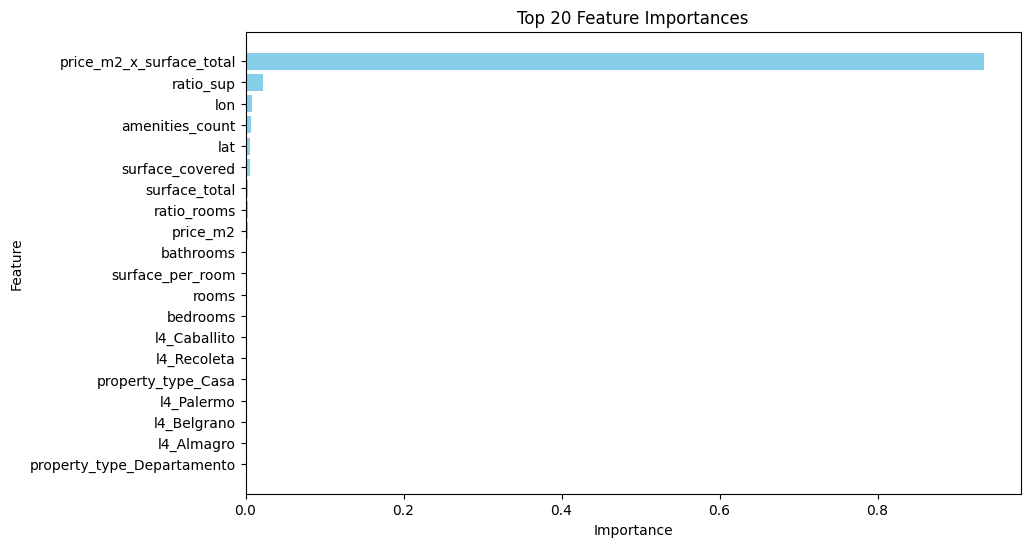

In [ ]:
import matplotlib.pyplot as plt


importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las top N importancias
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].iloc[:top_n], importance_df['Importance'].iloc[:top_n], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importances'.format(top_n))
plt.show()

In [ ]:
importance_df.sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
11,price_m2_x_surface_total,0.934242
7,ratio_sup,0.021677
1,lon,0.007971
12,amenities_count,0.007212
0,lat,0.006287
6,surface_covered,0.005356
5,surface_total,0.003394
8,ratio_rooms,0.002608
10,price_m2,0.002500
4,bathrooms,0.002491


In [ ]:
df_errores = X.copy()

# Convertir los valores reales y predicciones al espacio original
y_real = y
y_pred = reg.predict(X)  # Predicciones para todo el dataset

# Añadir las columnas de precios reales, predicciones y errores
df_errores['price_real'] = y_real
df_errores['price_predicho'] = y_pred
df_errores['error_absoluto'] =y_pred - y_real
df_errores['error_relativo'] = df_errores['error_absoluto'] / (y_real + 0.0001)  # Para evitar división por 0


In [ ]:
df_errores['price_real'] = df_errores['price_real'].round(2)
df_errores['price_predicho'] = df_errores['price_predicho'].round(2)
df_errores['error_absoluto'] = df_errores['error_absoluto'].round(2)
df_errores['error_relativo'] = df_errores['error_relativo'].round(4)  # Más precisión para porcentajes

In [ ]:
# Ordenar por error relativo
df_errores_ordenado = df_errores.sort_values(by='error_relativo', ascending=False)

In [ ]:
df_errores_ordenado.iloc[:,4:]

,bathrooms,surface_total,surface_covered,ratio_sup,ratio_rooms,surface_per_room,price_m2,price_m2_x_surface_total,amenities_count,l4_Abasto,...,l4_Villa Soldati,l4_Villa Urquiza,l4_Villa del Parque,property_type_Casa,property_type_Cochera,property_type_Departamento,price_real,price_predicho,error_absoluto,error_relativo
id,,,,,,,,,,,,,,,,,,,,,
88333,2.0,75.0,67.0,0.893332,0.040000,24.999167,3148.622974,2.361467e+05,8,0,...,0,0,0,0,0,1,43000.0,254362.24,211362.24,4.9154
362225,1.0,46.0,46.0,0.999998,0.043478,22.998850,3148.622974,1.448367e+05,0,0,...,0,0,0,0,0,1,30000.0,127841.07,97841.07,3.2614
840807,1.0,181.0,169.0,0.933701,0.011050,90.495475,3132.523522,5.669868e+05,0,0,...,0,0,0,0,0,1,108000.0,454018.77,346018.77,3.2039
131099,1.0,40.0,40.0,0.999998,0.050000,19.999000,2556.766915,1.022707e+05,9,0,...,0,0,0,0,0,1,28615.0,102713.65,74098.65,2.5895
301871,1.0,270.0,270.0,1.000000,0.014815,67.498313,2577.193138,6.958421e+05,3,0,...,0,0,0,1,0,0,179000.0,629989.44,450989.44,2.5195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831658,3.0,492.0,359.0,0.729675,0.006098,163.994534,1785.593526,8.785120e+05,6,0,...,0,0,0,1,0,0,1250000.0,727480.36,-522519.64,-0.4180
15008,3.0,615.0,300.0,0.487805,0.004878,204.993167,1785.593526,1.098140e+06,2,0,...,0,0,0,1,0,0,1300000.0,749677.57,-550322.43,-0.4233
633020,0.0,20.0,20.0,0.999995,0.000000,200000.000000,1433.721253,2.867443e+04,1,0,...,0,0,0,0,1,0,48000.0,27405.09,-20594.91,-0.4291
